In [1]:
#% matplotlib inline

from datetime import datetime 
import h5py
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
cmap = cm.get_cmap('Blues')
import random
from scipy import signal, cluster, stats
from multiprocessing import Pool
import scipy as sp
from scipy import linalg
from matplotlib import animation, rc
from IPython.display import HTML
import cairosvg
from PIL import Image


In [2]:
filename = 'Data/average_filters_by_cluster.npy'

cluster_data = np.load(filename)

ipl_depth_order = [0, 3, 9, 7, 11, 2, 8, 5, 6, 1, 10, 12, 4]

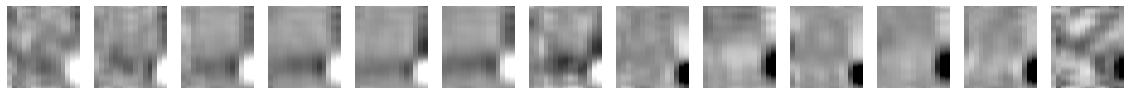

In [3]:
cluster_data_cropped = cluster_data[10:-10, 5:20, :]

fig, ax = plt.subplots(1, 13, figsize=(20,1.5))  
for i, clust in enumerate(ipl_depth_order):
    ax[i].imshow(cluster_data_cropped[:,:,clust]/np.linalg.norm(cluster_data_cropped[:,:,clust]), cmap='Greys_r', aspect='auto', vmin=-0.05, vmax=0.05)
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    ax[i].axis('off')

# Figpath = 'Fig_temp/'
# savename = Figpath+"Cropped_original_RFs.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

In [4]:
#292 pixels corresponding to 0.4672 s (0.0016 s/pixel)

In [5]:
#interpolation
up_resolution_space = (1625/1600)*20
up_resolution_time = 1.6
xp = np.arange(cluster_data_cropped.shape[1])
tp = np.arange(cluster_data_cropped.shape[0])

x = np.arange(0, cluster_data_cropped.shape[1]-1, (cluster_data_cropped.shape[1]-1)/(up_resolution_space*cluster_data_cropped.shape[1])) #number of points in katrin's resolution
t = np.arange(0, cluster_data_cropped.shape[0]-1, (cluster_data_cropped.shape[0]-0.5)/(up_resolution_time*cluster_data_cropped.shape[0]))

interpolated_filters = np.zeros((np.int(np.round(up_resolution_time*cluster_data_cropped.shape[0])), np.int(np.round(up_resolution_space*cluster_data_cropped.shape[1])), cluster_data_cropped.shape[2]))

for i in range(13): 
    #svd
    u, s, vh = np.linalg.svd(cluster_data_cropped[:,:,i].T)
    
    #interpolation of the space components
    u_interp = np.zeros((x.shape[0],u.shape[1]))
    for j in range(u.shape[1]):
        fp = u[:, j]
        f_interp = np.interp(x, xp, fp)
        u_interp[:, j] = f_interp
        
    #interpolation of the time components
    vh_interp = np.zeros((vh.shape[0],t.shape[0]))
    for k in range(vh.shape[1]):
        fp = vh[k, :]
        f_interp = np.interp(t, tp, fp)
        vh_interp[k, :] = f_interp
    
    #reconstruction of filters
    new_filt = np.outer(vh_interp[0,:], u_interp[:,0])*s[0]+np.outer(vh_interp[1,:], u_interp[:,1])*s[1]+np.outer(vh_interp[2,:], u_interp[:,2])*s[2]#+np.outer(vh[3,:], u_interp[:,3])*s[3]+np.outer(vh[4,:], u_interp[:,4])*s[4]
    interpolated_filters[:, :, i] = new_filt

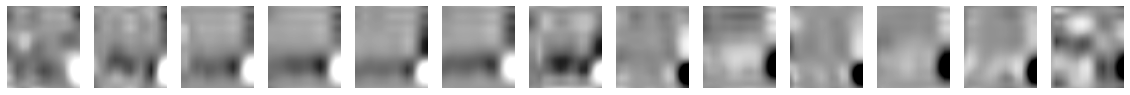

In [6]:
fig, ax = plt.subplots(1, 13, figsize=(20,1.5))  
for i, clust in enumerate(ipl_depth_order):
    ax[i].imshow(interpolated_filters[:,:,clust]/np.linalg.norm(interpolated_filters[:,:,clust]),cmap='Greys_r', aspect='auto', vmin=-0.008, vmax=0.008)
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    ax[i].axis('off')

# Figpath = 'Fig_temp/'
# savename = Figpath+"Cropped_interpolated_RFs.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

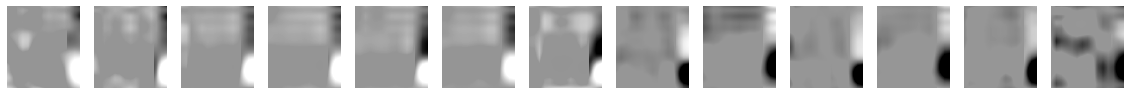

In [7]:
# enhance the surround
polarity = [1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1]

scalar_surround = 0.01 # replace for other amounts; 0.5, 1, 2, 3

interpolated_filters_enhanced = np.zeros(interpolated_filters.shape)

fig, ax = plt.subplots(1, 13, figsize=(20,1.5))  
for i, clust in enumerate(ipl_depth_order):
    spline = interpolated_filters[:, :, clust]
    if polarity[clust]==-1:
        spline = np.where(spline>0, spline*scalar_surround, spline)#try enhancing the surround
        spline[:, 250:] = interpolated_filters[:,250:,clust] #keep the center the same
    else:
        spline = np.where(spline<0, spline*scalar_surround, spline)
        spline[:, 250:] = interpolated_filters[:,250:,clust]

    ax[i].imshow(spline/np.linalg.norm(spline[:,:]), cmap='Greys_r', aspect='auto', vmin=-0.008, vmax=0.008)
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    ax[i].axis('off')
#     axes=plt.gca()

    interpolated_filters_enhanced[:,:,clust] = spline

# Figpath = 'Fig_temp/'
# savename = Figpath+"Cropped_interpolated_"+str(scalar_surround)+"_RFs.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

In [8]:
# # remove everything but the center
# polarity = [1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1]
# time_cut = 285
# scalar_surround = 0.001

# interpolated_filters_enhanced = np.zeros(interpolated_filters.shape)

# fig, ax = plt.subplots(1, 13, figsize=(20,1.5))  
# for i, clust in enumerate(ipl_depth_order):
#     spline = interpolated_filters[:, :, clust]
#     if polarity[clust]==-1:
#         spline = np.where(spline, spline*scalar_surround, spline)#try enhancing the surround
#         spline[time_cut:, 250:] = interpolated_filters[time_cut:,250:,clust] #keep the center the same
#     else:
#         spline = np.where(spline, spline*scalar_surround, spline)
#         spline[time_cut:, 250:] = interpolated_filters[time_cut:,250:,clust]

#     ax[i].imshow(spline/np.linalg.norm(spline[:,:]), cmap='Greys_r', aspect='auto', vmin=-0.008, vmax=0.008)
#     ax[i].set_yticklabels([])
#     ax[i].set_xticklabels([])
#     ax[i].axis('off')
# #     axes=plt.gca()

#     interpolated_filters_enhanced[:,:,clust] = spline

# # Figpath = 'Fig_temp/'
# # savename = Figpath+"Cropped_interpolated_"+str(scalar_surround)+"_RFs.pdf"
# # plt.savefig(savename, transparent=True, bbox_inches='tight')

In [9]:
#make them symmetric
cluster_data_mirrored = np.zeros((interpolated_filters.shape[0], (interpolated_filters.shape[1])*2+1, interpolated_filters.shape[2]))
cluster_data_mirrored_enhanced = np.zeros((interpolated_filters.shape[0], (interpolated_filters.shape[1])*2+1, interpolated_filters.shape[2]))

for i in range(13):
    cluster_data_mirrored[:, :interpolated_filters.shape[1], i] = interpolated_filters[:,:,i]
    cluster_data_mirrored[:, interpolated_filters.shape[1], i] = interpolated_filters[:,-1,i] # adding one point in the middle
    temp_data = interpolated_filters[:,:,i]
    cluster_data_mirrored[:, interpolated_filters.shape[1]+1:, i] = temp_data[:, : :-1]
    
    cluster_data_mirrored_enhanced[:, :interpolated_filters.shape[1], i] = interpolated_filters_enhanced[:,:,i]
    cluster_data_mirrored_enhanced[:, interpolated_filters.shape[1], i] = interpolated_filters_enhanced[:,-1,i] # adding one point in the middle
    temp_data = interpolated_filters_enhanced[:,:,i]
    cluster_data_mirrored_enhanced[:, interpolated_filters.shape[1]+1:, i] = temp_data[:, : :-1]
    


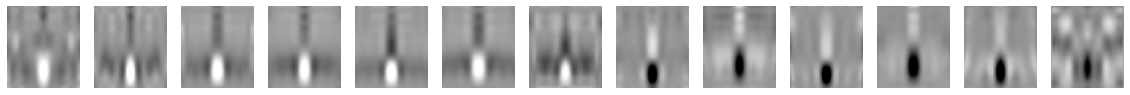

In [10]:
fig, ax = plt.subplots(1, 13, figsize=(20,1.5))  
for i, clust in enumerate(ipl_depth_order):
    ax[i].imshow(cluster_data_mirrored[:,:,clust]/np.linalg.norm(cluster_data_mirrored[:,:,clust]),cmap='Greys_r', aspect='auto', vmin=-0.008, vmax=0.008)
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    ax[i].axis('off')

# Figpath = 'Fig_temp/'
# savename = Figpath+"Cropped_interpolated_mirrored_RFs.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

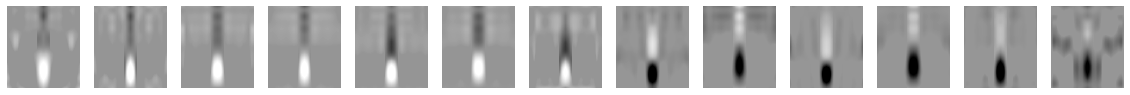

In [11]:
fig, ax = plt.subplots(1, 13, figsize=(20,1.5))  
for i, clust in enumerate(ipl_depth_order):
    ax[i].imshow(cluster_data_mirrored_enhanced[:,:,clust]/np.linalg.norm(cluster_data_mirrored[:,:,clust]),cmap='Greys_r', aspect='auto', vmin=-0.008, vmax=0.008)
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    ax[i].axis('off')

# Figpath = 'Fig_temp/'
# savename = Figpath+"Cropped_interpolated_"+str(scalar_surround)+"mirrored_RFs.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

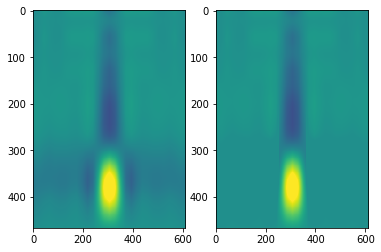

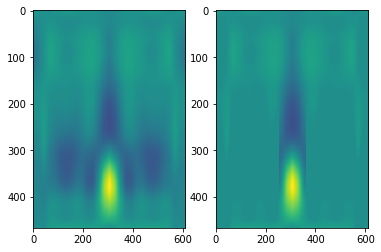

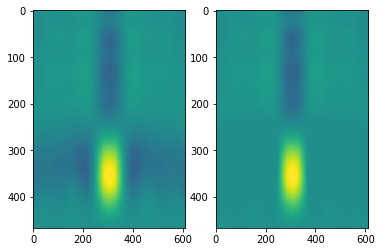

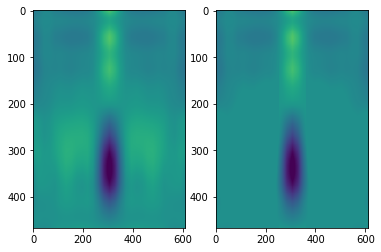

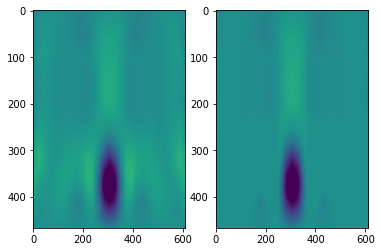

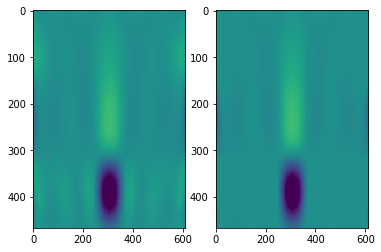

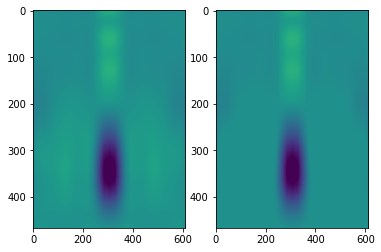

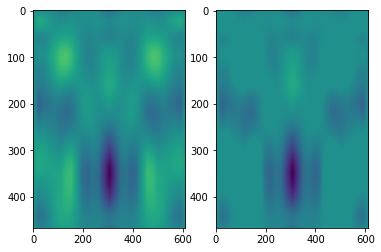

In [12]:
for i in [11, 8, 2, 6, 12, 1, 10, 4]:
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(cluster_data_mirrored[:, :, i]/np.linalg.norm(cluster_data_mirrored[:, :, i]), aspect='auto', vmin=-0.01, vmax=0.01)
    ax[1].imshow(cluster_data_mirrored_enhanced[:, :, i]/np.linalg.norm(cluster_data_mirrored[:, :, i]), aspect='auto', vmin=-0.01, vmax=0.01)

#     ax[1].colorbar()

In [13]:
#dividing by the norm
cluster_data_mirrored_norm = np.zeros(cluster_data_mirrored.shape)
cluster_data_mirrored_enhanced_norm = np.zeros(cluster_data_mirrored.shape)

for i in range(13):

    cluster_data_mirrored_norm[:,:,i] = cluster_data_mirrored[:, :, i]/np.linalg.norm(cluster_data_mirrored[:, :, i])
    cluster_data_mirrored_enhanced_norm[:,:,i] = cluster_data_mirrored_enhanced[:, :, i]/np.linalg.norm(cluster_data_mirrored[:, :, i])

cluster_data_mirrored_norm_padded = np.pad(cluster_data_mirrored_norm, ((0,0), (507,507), (0, 0)))
cluster_data_mirrored_enhanced_norm_padded = np.pad(cluster_data_mirrored_enhanced_norm, ((0,0), (507,507), (0, 0)))

In [14]:
def get_svg_parameters_on_screen(dendrite_length, moving_bar_length, stimulus_velocity,
                             starting_point, distance_covered, real_time_lag, time_points, space_per_pixel):
    temporal_conversion = time_points / real_time_lag  # From seconds to pixel.
    spatial_conversion = 1 / space_per_pixel  # From um to pixel.

    # Moving bar is already fully on screen at t = 0
    distance_moved = distance_covered - moving_bar_length  # [um]
    stimulation_time = (distance_moved / stimulus_velocity)  # [s]

    # Convert from seconds & um to pixel
    stimulation_time_pixel = stimulation_time * temporal_conversion

    distance_moved_pixel = distance_moved * spatial_conversion
    dendrite_length_pixel = dendrite_length * spatial_conversion
    moving_bar_length_pixel = moving_bar_length * spatial_conversion
    starting_point_pixel = starting_point * spatial_conversion
    distance_covered_pixel = distance_covered * spatial_conversion

    # Slope of diagonal
    slope = -stimulation_time_pixel / distance_moved_pixel

    # Calculate thickness of diagonal
    alpha = np.arctan(stimulation_time_pixel / distance_moved_pixel)
    diagonal_thickness = moving_bar_length_pixel * np.sin(alpha)

    # Calculate coordinates for beginning & end of diagonal
    # Diagonal starts and ends out of picture to allow for a smooth & exact picture.
    x_start = starting_point_pixel
    x_stop = x_start + distance_covered_pixel

    y_start = (moving_bar_length_pixel / 2) * slope  # Negative
    y_stop = stimulation_time_pixel - y_start

    return (stimulation_time_pixel, dendrite_length_pixel,
            diagonal_thickness,
            x_start, x_stop, y_start, y_stop)

In [15]:
#pull the convolution parameters for modeling
convolution_params = {}
file = h5py.File('Data/Fig2_3_S3.hdf5', 'r')
dict_group_load = file['convolution_params']
dict_group_keys = dict_group_load.keys()
for k in dict_group_keys:
    convolution_params[k]= np.float(dict_group_load[k][0])

In [16]:
def convolved_dsis(velocity, convolution_params):
    # velocity tuning

    # get the stimulus for convolution

    polarity = [1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1]
    cluster_avg_depth = [0.01921873, 0.66179005, 0.37403534, 0.12944179, 0.87252108,
       0.54089452, 0.62813755, 0.20017531, 0.45394782, 0.12981353,
       0.70834325, 0.31202559, 0.81919496]
    
    convolution_params['stimulus_velocity'] = velocity # WARNING altering this to play around with velocity tuning
#     real_time_lag, time_points = (NoiseDesignMatrix2() & field).fetch1('real_time_lag', 'time_points')
    #     space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & field).fetch1('box_dx_um', 'box_dy_um')
    #     if space_per_pixelx < space_per_pixely:  # check which is the shorter dimension of the stimulus
    #         space_per_pixel = space_per_pixelx
    #     else:
    #         space_per_pixel = space_per_pixely
    space_per_pixel = 1600/1625
    #WARNING check the time values, these might be OFF!
    real_time_lag = 1
    time_points = 467

    time, dend, diag, x_start, x_stop, y_start, y_stop = get_svg_parameters_on_screen(
        convolution_params['dendrite_length'],
        convolution_params['moving_bar_length'],
        convolution_params['stimulus_velocity'],
        convolution_params['starting_point'],
        convolution_params['distance_covered'],
        real_time_lag,
        time_points,
        space_per_pixel
    )

    string_svg = """<svg width="{0}" height="{1}" viewBox="0 0 {2} {3}">
        <rect x="0" y="0" width="{4}" height="{5}" fill="black" />
          <line x1="{6}" y1="{7}" x2="{8}" y2="{9}"
              stroke-width="{10}" stroke="white" stroke-linecap="square"/>
        </svg>""".format(dend, time, dend, time, dend, time, x_start, y_start, x_stop, y_stop, diag)

    folder_str = 'Data/'
    file_name = str(1)
    name_svg = folder_str + file_name + ".svg"
    name_png = folder_str + file_name + ".png"

    new_file = open(name_svg, "wt")
    new_file.write(string_svg)
    new_file.close()

    cairosvg.svg2png(url=name_svg, write_to=name_png)

    stimulus_image = np.array(Image.open(name_png).convert('L'))


    #get convolved responses

    #     cluster_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,]
    dsi = np.zeros(13)
    dsi_off = np.zeros(13)
    if velocity == 1000:
        inward = [None] * 13
        outward = [None] * 13
    
    fig, ax = plt.subplots(1, 13, figsize=(20, 1.6666))
    for i, clust in enumerate(ipl_depth_order):
        # get the necessaries
        # spline = (NoiseSplineRF2 & key).fetch1('spl')
        spline = cluster_data_mirrored_norm_padded[:,:,clust]#cluster_data_mirrored_enhanced_norm_padded[:,:,clust]
        edge_buffer_space = 600 #(ConvolutionKernelParams() & key).fetch1('edge_buffer')
        edge_buffer_time = 10
        # stimulus_image = (ConvolutionStimulus() & key).fetch1('stimulus_image')
        stimulus_image_rev = np.flip(stimulus_image, axis=0)
        kernel_type = 'left'#(ConvolutionKernelParams() & key).fetch1('kernel_type')
        # space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & key).fetch1('box_dx_um', 'box_dy_um')

        # set up and crop the kernel
        kernel_length = stimulus_image.shape[1]  # needs to be the same length as the stimulus

        # get the location of the RF center in the kernel
        spline_temp = spline[edge_buffer_time:-edge_buffer_time, :]
        index_max = np.unravel_index(np.argmax(np.abs(spline_temp), axis=None), spline_temp.shape)
        peak_y = index_max[1]

        # crop the kernel depending on the type of experiment
        if kernel_type == 'right':
            spline_cut = spline[edge_buffer_time:-edge_buffer_time, np.int(peak_y - 1):np.int(peak_y + kernel_length - 1)]
        elif kernel_type == 'left':
            spline_cut = spline[edge_buffer_time:-edge_buffer_time, np.int(peak_y + 1 - kernel_length):np.int(peak_y + 1)]
        elif kernel_type == 'full':
            spline_cut = spline[edge_buffer_time:-edge_buffer_time,
                         0:kernel_length]  # should be full kernel, just adding space range just in case
        elif kernel_type == 'centered':
            spline_cut = spline[edge_buffer_time:-edge_buffer_time,
                         np.int(np.floor(peak_y - kernel_length / 2)):np.int(np.floor(peak_y + kernel_length / 2))]
        else:
            spline_cut = spline  # just to make the code happy, this should never be the option
        # can code in other possibilities here...

        # check whether cut spline is big enough
        space_length = spline_cut.shape[1]
        if kernel_length == space_length:
            empty_flag = 0
            # setup output variables
            convolved_response = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))
            convolved_response_rev = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))

            # loop through x positions and convolve
            for x_position in range(stimulus_image.shape[1]):
                ker = np.flip(spline_cut[:, x_position])
                img = stimulus_image[:, x_position]
                img2 = stimulus_image_rev[:, x_position]
                # and then convolve these two
                convolved_response[:, x_position] = np.convolve(a=img, v=ker, mode='full')
                convolved_response_rev[:, x_position] = np.convolve(a=img2, v=ker, mode='full')
        else:
            empty_flag = 1
            convolved_response = []
            convolved_response_rev = []

        response = np.sum(convolved_response, axis=1)
        response_rev = np.sum(convolved_response_rev, axis=1)
        max_response = np.amax(response)
        max_response_rev = np.amax(response_rev)
        max_response_off = np.amin(response)
        max_response_rev_off = np.amin(response_rev)
        dsi[clust] = (max_response - max_response_rev) / (max_response + max_response_rev)
    #         print(max_response, max_response_rev)
        dsi_off[clust] = (max_response_off - max_response_rev_off) / (max_response_off + max_response_rev_off)
        if velocity == 1000:
            inward[clust] = [response*polarity[clust]]
            outward[clust] = [response_rev*polarity[clust]]
        
    #         dsi_all = np.where(cluster_avg_depth<0.5, dsi, dsi_off)
    #     print(dsi, dsi_off)
    #     plt.figure()
        ax[i].plot(response*polarity[clust], color='b')
        ax[i].plot(response_rev*polarity[clust], color='k')
        ax[i].axhline(color='k', linestyle='dotted')
        ax[i].set_ylim([-2000,4000])
    #     ax[i].set_yticklabels([])
    #     ax[i].set_xticklabels([])
    #     ax[i].axis('off')

    # Figpath = 'Fig_temp/'
    # savename = Figpath+"Convolved_responses.pdf"
    # plt.savefig(savename, transparent=True, bbox_inches='tight')
    return dsi, dsi_off#, outward, inward

In [17]:
def convolved_dsis_enhanced(velocity, convolution_params):
    # velocity tuning

    # get the stimulus for convolution

    polarity = [1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1]
    cluster_avg_depth = [0.01921873, 0.66179005, 0.37403534, 0.12944179, 0.87252108,
       0.54089452, 0.62813755, 0.20017531, 0.45394782, 0.12981353,
       0.70834325, 0.31202559, 0.81919496]

    convolution_params['stimulus_velocity'] = velocity # WARNING altering this to play around with velocity tuning
#     real_time_lag, time_points = (NoiseDesignMatrix2() & field).fetch1('real_time_lag', 'time_points')
    #     space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & field).fetch1('box_dx_um', 'box_dy_um')
    #     if space_per_pixelx < space_per_pixely:  # check which is the shorter dimension of the stimulus
    #         space_per_pixel = space_per_pixelx
    #     else:
    #         space_per_pixel = space_per_pixely
    space_per_pixel = 1600/1625
    #WARNING check the time values, these might be OFF!
    real_time_lag = 1
    time_points = 467

    time, dend, diag, x_start, x_stop, y_start, y_stop = get_svg_parameters_on_screen(
        convolution_params['dendrite_length'],
        convolution_params['moving_bar_length'],
        convolution_params['stimulus_velocity'],
        convolution_params['starting_point'],
        convolution_params['distance_covered'],
        real_time_lag,
        time_points,
        space_per_pixel
    )

    string_svg = """<svg width="{0}" height="{1}" viewBox="0 0 {2} {3}">
        <rect x="0" y="0" width="{4}" height="{5}" fill="black" />
          <line x1="{6}" y1="{7}" x2="{8}" y2="{9}"
              stroke-width="{10}" stroke="white" stroke-linecap="square"/>
        </svg>""".format(dend, time, dend, time, dend, time, x_start, y_start, x_stop, y_stop, diag)

    folder_str = 'Data/'
    file_name = str(1)
    name_svg = folder_str + file_name + ".svg"
    name_png = folder_str + file_name + ".png"

    new_file = open(name_svg, "wt")
    new_file.write(string_svg)
    new_file.close()

    cairosvg.svg2png(url=name_svg, write_to=name_png)

    stimulus_image = np.array(Image.open(name_png).convert('L'))


    #get convolved responses

    #     cluster_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,]
    dsi = np.zeros(13)
    dsi_off = np.zeros(13)
    if velocity == 1000:
        inward = [None] * 13
        outward = [None] * 13
    
    fig, ax = plt.subplots(1, 13, figsize=(20, 1.6666))
    for i, clust in enumerate(ipl_depth_order):
        # get the necessaries
        # spline = (NoiseSplineRF2 & key).fetch1('spl')
        spline = cluster_data_mirrored_enhanced_norm_padded[:,:,clust]#cluster_data_mirrored_enhanced_norm_padded[:,:,clust]
        edge_buffer_space = 600 #(ConvolutionKernelParams() & key).fetch1('edge_buffer')
        edge_buffer_time = 10
        # stimulus_image = (ConvolutionStimulus() & key).fetch1('stimulus_image')
        stimulus_image_rev = np.flip(stimulus_image, axis=0)
        kernel_type = 'left'#(ConvolutionKernelParams() & key).fetch1('kernel_type')
        # space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & key).fetch1('box_dx_um', 'box_dy_um')

        # set up and crop the kernel
        kernel_length = stimulus_image.shape[1]  # needs to be the same length as the stimulus

        # get the location of the RF center in the kernel
        spline_temp = spline[edge_buffer_time:-edge_buffer_time, :]
        index_max = np.unravel_index(np.argmax(np.abs(spline_temp), axis=None), spline_temp.shape)
        peak_y = index_max[1]

        # crop the kernel depending on the type of experiment
        if kernel_type == 'right':
            spline_cut = spline[edge_buffer_time:-edge_buffer_time, np.int(peak_y - 1):np.int(peak_y + kernel_length - 1)]
        elif kernel_type == 'left':
            spline_cut = spline[edge_buffer_time:-edge_buffer_time, np.int(peak_y + 1 - kernel_length):np.int(peak_y + 1)]
        elif kernel_type == 'full':
            spline_cut = spline[edge_buffer_time:-edge_buffer_time,
                         0:kernel_length]  # should be full kernel, just adding space range just in case
        elif kernel_type == 'centered':
            spline_cut = spline[edge_buffer_time:-edge_buffer_time,
                         np.int(np.floor(peak_y - kernel_length / 2)):np.int(np.floor(peak_y + kernel_length / 2))]
        else:
            spline_cut = spline  # just to make the code happy, this should never be the option
        # can code in other possibilities here...

        # check whether cut spline is big enough
        space_length = spline_cut.shape[1]
        if kernel_length == space_length:
            empty_flag = 0
            # setup output variables
            convolved_response = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))
            convolved_response_rev = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))

            # loop through x positions and convolve
            for x_position in range(stimulus_image.shape[1]):
                ker = np.flip(spline_cut[:, x_position])
                img = stimulus_image[:, x_position]
                img2 = stimulus_image_rev[:, x_position]
                # and then convolve these two
                convolved_response[:, x_position] = np.convolve(a=img, v=ker, mode='full')
                convolved_response_rev[:, x_position] = np.convolve(a=img2, v=ker, mode='full')
        else:
            empty_flag = 1
            convolved_response = []
            convolved_response_rev = []

        response = np.sum(convolved_response, axis=1)
        response_rev = np.sum(convolved_response_rev, axis=1)
        max_response = np.amax(response)
        max_response_rev = np.amax(response_rev)
        max_response_off = np.amin(response)
        max_response_rev_off = np.amin(response_rev)
        dsi[clust] = (max_response - max_response_rev) / (max_response + max_response_rev)
    #         print(max_response, max_response_rev)
        dsi_off[clust] = (max_response_off - max_response_rev_off) / (max_response_off + max_response_rev_off)
        if velocity == 1000:
            inward[clust] = [response*polarity[clust]]
            outward[clust] = [response_rev*polarity[clust]]
        
    #         dsi_all = np.where(cluster_avg_depth<0.5, dsi, dsi_off)
    #     print(dsi, dsi_off)
    #     plt.figure()
        ax[i].plot(response*polarity[clust], color='b')
        ax[i].plot(response_rev*polarity[clust], color='k')
        ax[i].axhline(color='k', linestyle='dotted')
        ax[i].set_ylim([-2000,4000])
    #     ax[i].set_yticklabels([])
    #     ax[i].set_xticklabels([])
    #     ax[i].axis('off')

    # Figpath = 'Fig_temp/'
    # savename = Figpath+"Convolved_responses.pdf"
    # plt.savefig(savename, transparent=True, bbox_inches='tight')
    return dsi, dsi_off#, outward, inward

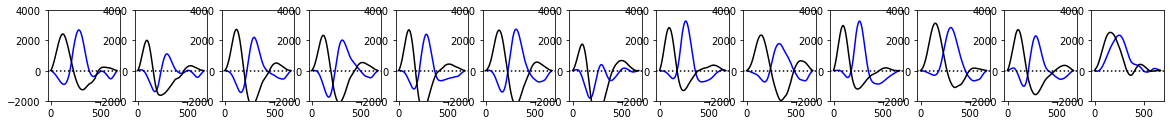

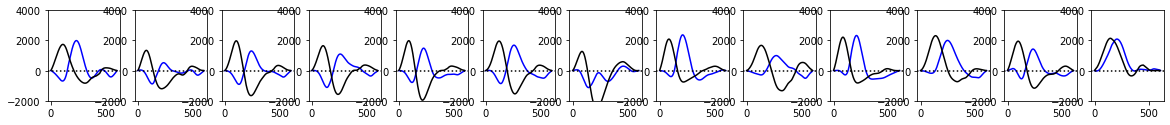

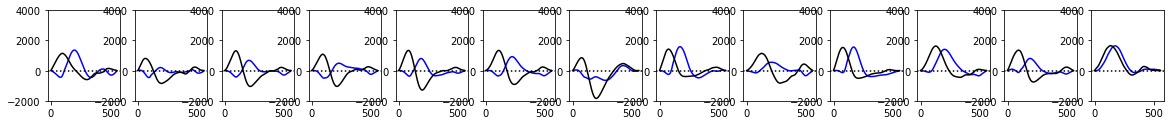

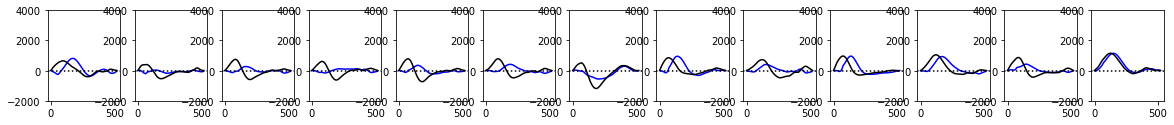

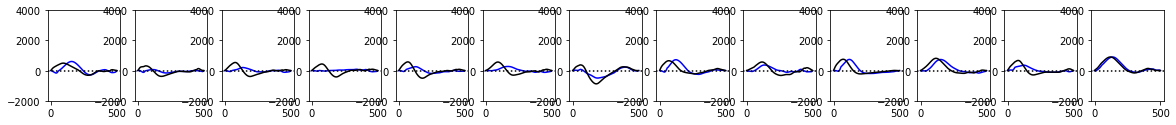

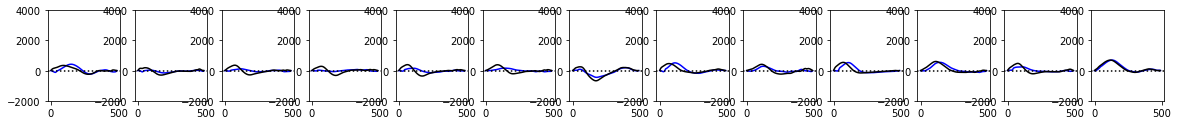

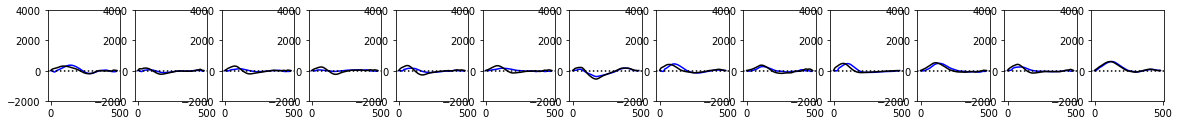

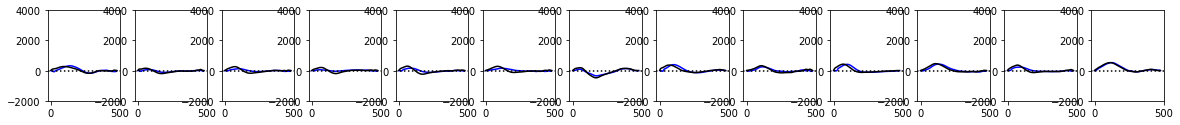

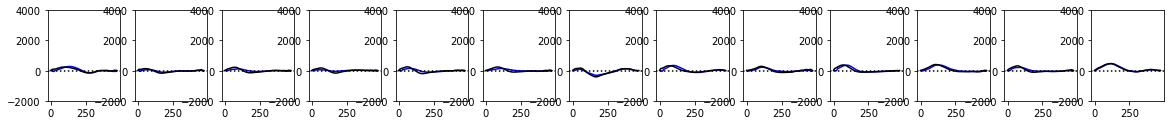

In [18]:
velocities = [250, 350, 500, 750, 1000, 1250, 1500, 1750, 2000]
# velocities = [1000]
cluster_avg_depth = np.array([0.01921873, 0.66179005, 0.37403534, 0.12944179, 0.87252108,
       0.54089452, 0.62813755, 0.20017531, 0.45394782, 0.12981353,
       0.70834325, 0.31202559, 0.81919496])

dsi_all_all = np.zeros((len(velocities), 13))

for i, velocity in enumerate(velocities):
    dsi, dsi_off = convolved_dsis(velocity, convolution_params) #, outward, inward 
    dsi_all_all[i, :] = np.where(cluster_avg_depth<0.5, dsi, dsi_off)

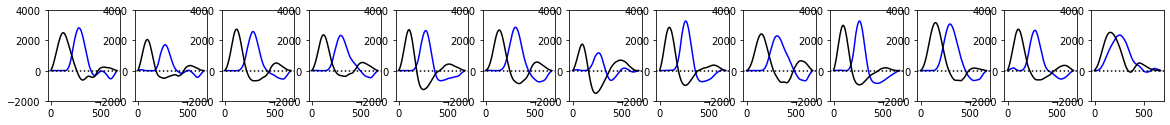

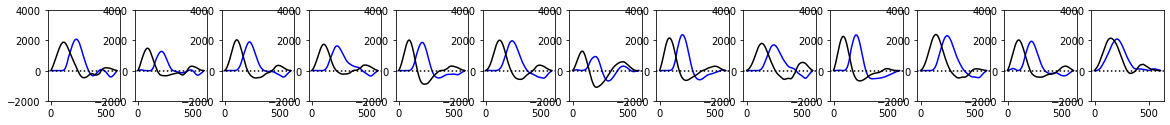

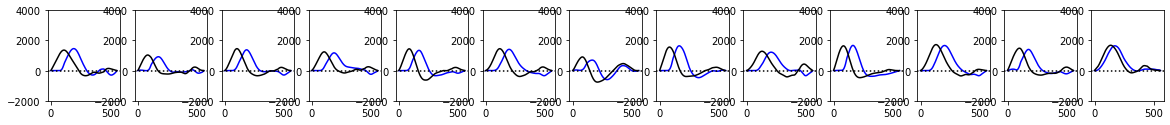

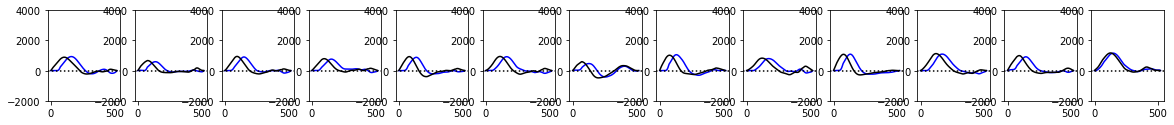

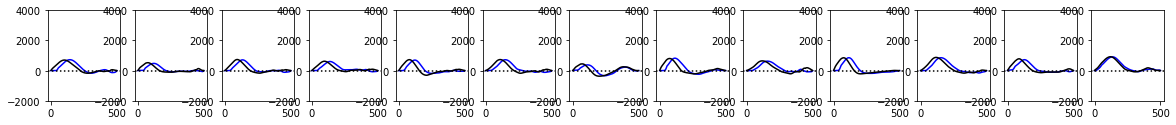

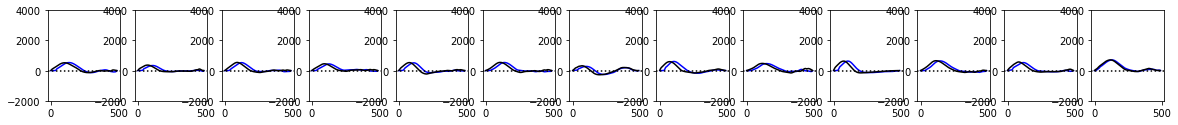

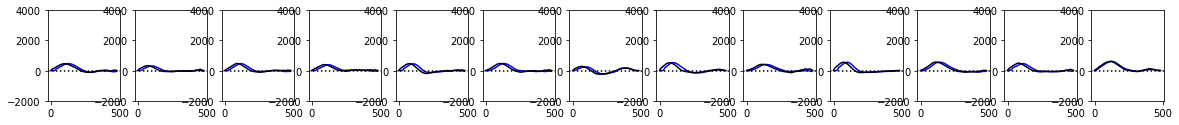

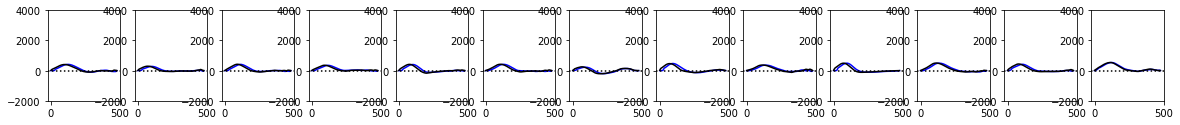

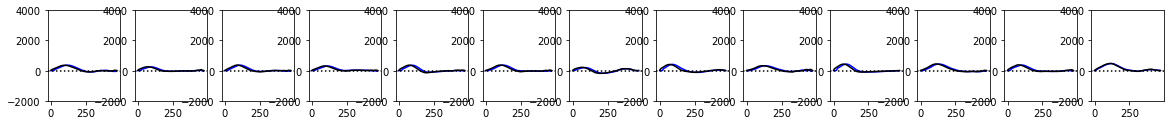

In [19]:
# velocities = [250, 350, 500, 750, 1000, 1250, 1500, 1750, 2000]
# # velocities = [1000]
# cluster_avg_depth = np.array([0.01921873, 0.66179005, 0.37403534, 0.12944179, 0.87252108,
#        0.54089452, 0.62813755, 0.20017531, 0.45394782, 0.12981353,
#        0.70834325, 0.31202559, 0.81919496])

dsi_all_all_enhanced = np.zeros((len(velocities), 13))

for i, velocity in enumerate(velocities):
    dsi, dsi_off = convolved_dsis_enhanced(velocity, convolution_params) #, outward, inward
    dsi_all_all_enhanced[i, :] = np.where(cluster_avg_depth<0.5, dsi, dsi_off)

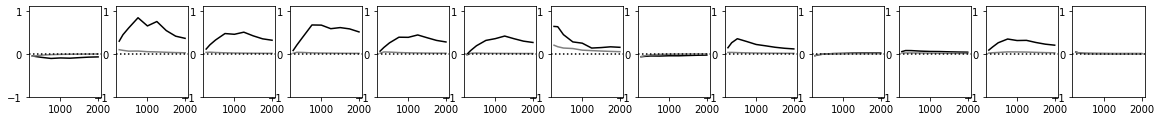

In [20]:
fig, ax = plt.subplots(1, 13, figsize=(20, 1.6666))
for i, clust in enumerate(ipl_depth_order):

    ax[i].plot(velocities, dsi_all_all[:, clust]*-1, color='k')
    ax[i].plot(velocities, dsi_all_all_enhanced[:, clust]*-1, color='grey')
    ax[i].set_ylim([-1, 1.1])
    ax[i].axhline(color='k', linestyle='dotted')
#     ax[i].set_yticklabels([])
#     ax[i].set_xticklabels([])
#     ax[i].axis('off')
# plt.legend()


# Figpath = 'Fig_temp/'
# savename = Figpath+"Velocity_tuning_interpolated_clusters_100_200_surround.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')
# plt.show()

In [21]:
# make a movie

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import animation, rc
from IPython.display import HTML

In [22]:
cm = plt.get_cmap('Greys_r') #sns.diverging_palette(20, 220, n=50)
# cmap_name = 'my_list'
# n_bins = 50
# cm = LinearSegmentedColormap.from_list(cmap_name, palette, N=n_bins)
cm.set_bad(color='k')


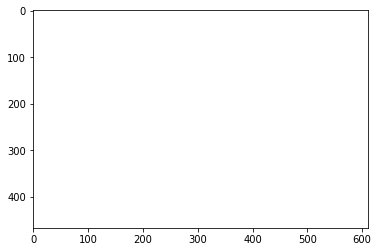

In [23]:
# img = average_frames # some array of images

# maximum = 3.0 #np.nanmax(img)*0.9
# minimum = 0.0 #np.nanmin(img)*1.1

frames = [] # for storing the generated images
fig = plt.figure()
for i in ipl_depth_order:
    frames.append([plt.imshow(cluster_data_mirrored[:,:,i]/np.linalg.norm(cluster_data_mirrored[:,:,clust]),cmap='Greys_r', aspect='auto', vmin=-0.01, vmax=0.01)]) #cm.viridis #Blues

ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=10)
# ani.save('test_movie.mp4')
plt.show()

In [24]:
HTML(ani.to_jshtml())

In [25]:
# writergif = animation.PillowWriter(fps=2) 
# ani.save('rf_movie.gif', writer=writergif)